# Point Mass Systems

This sub-project has as goal to develop mass-spring-damper models for vibrating doors in driving busses. The door will be assumed to be a point mass or a set of interconnected point masses. In the latter case, the point masses with be interconnected by spring anfd dampers (dashpots). The single point masses are assumed to have <b>no</b> physical dimnensions. These models are expected to act as a guide (reference, provide indications, rough estimates) in developing more detailed structural analysis and flexible multi-body dynamics models. 

We aim at: 
1. static analysis to estimate e.g. maximum displacement given a load); 
2. transient analysis to follow orbit of point mass(es) in time; 
3. eigenmode analysis to estimate dominant modes of the system; 
4. vivrational analysis subject to stochastic load; 

### Ask Students 
1. plot acceleration measured in g's; 
2. look into measured acceleration as externally applied acceleration; 
3. look into resonant frequency by computing FFT of acceleration in case of zero and non-zero damping; estimate spring constant from resonant frequency; observe resonant frequency is case that mass reduced; estimate damping constant from Fourier transform of a damped sine or cosine wave;   
4. look into resonant frequency by plotting the transfer function in case of zero and non-zero damping;

## Import Packages

In [1]:
using LinearAlgebra
using DifferentialEquations
using SparseArrays
using Plots
using LaTeXStrings
using BenchmarkTools 

Documentation of DifferentialEquations.jl  
<ul>
<li> <a href="https://diffeq.sciml.ai/dev/tutorials/ode_example/"> Examples as part of DifferentialEquations.jl </a>   
<li> <a href="https://diffeq.sciml.ai/stable/"> Documentation of DifferentialEquations.jl on Github </a>  
</ul>   

## Section 2/: Door as Single Point-Mass

In this section we simplify the door to be a point-mass (no dimensions). We imagine the point-mass to be attached to the bus via springs and dampers. We imagine the bus to drive (over various road conditions) and try to model (quantify) how the door will move accordingly. 

### Questions
- to do: plot the computed acceleration usng g's as unit; 
- in time domain: how to imposes measured force (given as mass times acceleration (as a function in time) with acceleration measured in a number of g's) as forcing function in the differential equation?  
- in Laplace domain: how to solve the same problem using Laplace transforms? Using PSDF of the recorded acceleration as forcing function? 

### Section 1.2/: Oscillating Point Mass: Time Domain Analysis

The example that follows was taken from here [https://stackoverflow.com/questions/60180865/2nd-order-odes-in-julia-using-differentialequations]. The way in which the problem is presented, however, contains a bug. Here we use the function SecondOrderProblem explained [https://diffeq.sciml.ai/stable/solvers/dynamical_solve/] (solvers page) and [https://diffeq.sciml.ai/stable/types/dynamical_types/] (problems page). In the notation of SecondOrderODEProblem, the velocity is numbered first (as can be verified by looking into the computed solution). 

To do:
- solve problem analytically, symbolically or using Laplace transforms to obtain more confidence in the solution obtained; 
- look into details of how time integration is performed (implicit vs. explicit, time step size vs. tolerances imposed);

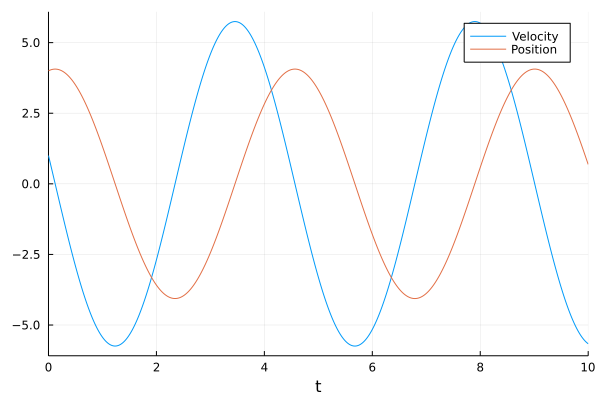

In [3]:
#..set mass of point mass 
m = 0.5 
#..set spring constant of spring 
k = 1.0                     

#..define the right-hand side of the ordinary differential equation of the equation of motion 
function mass_system!(du,u,p,t)
    # solve m \ddot{u} + k u = 0 or \ddot{u} = -(k/m) u 
   ddu = -(k/m)*u 
end

#..set initial position and velocity
u0 = 4.0                                      
v0 = 1.0 
#..set time begin and end forward 
tspan = (0.0,10.0)               

#..define ODE problem to be solved  
prob = SecondOrderODEProblem(mass_system!,v0,u0,tspan)

#..solve ODE problem 
sol = solve(prob)

#..plot solution of velocity and position as function of time 
#..velocity and position have vars=1 and vars=2, respectively. 
plot(sol,vars=1,label="Velocity")
plot!(sol,vars=2,label="Position")

The goal here is to obtain estimates of thec maximal displacement of the door. 

To do: 
- look into representative value of the mass door (between 25 kg and 30 kg), representative  value of the spring constant (assuming resonant frequency in range of 7 Hz to 12 Hz and setting angular frequency sqrt(k/m) equal to resonant frequency, see report by Lisette de Bruin), representative  value of the damping constant (by matching simulated and measured data) and representative  value of the external forcing (measured in multiples of 9.81 see 2021-student-report.pdf); 

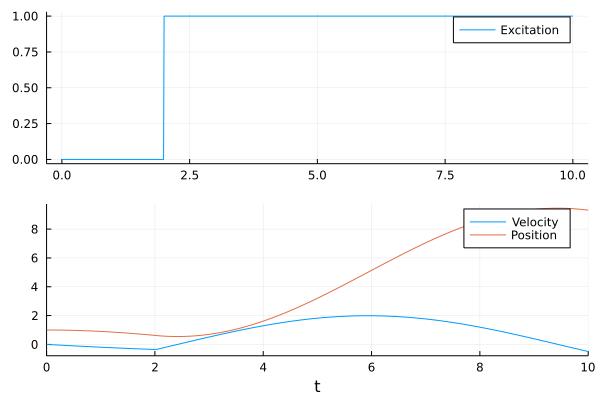

In [13]:
#..set mass of point mass 
m = 5 
#..set spring constant of spring 
k = 1.0 
#..set damping constant 
c = 0.0 

#..set imposed acceleration on the door 
function f(t)
    #return exp(-(t-2)^2/0.01)
    return t>=2 
end 

#..define the right-hand side of the ordinary differential equation of the equation of motion 
function mass_system(du,u,p,t)
    # solve \ddot{u} = -(k/m) u - (c/m) \dot u + f(t) 
    ddu = -(k/m)*u - (c/m)*du + f(t)
end

function mass_system!(ddu,du,u,p,t)
    # solve \ddot{u} = -(k/m) u - (c/m) \dot u + f(t) 
    ddu = -(k/m)*u - (c/m)*du + f(t)
end

#..set initial position and velocity
u0 = 1.0                                      
v0 = 0.0 
#..set time begin and end forward
tspan = (0.0,10.0)               

#..define ODE problem to be solved  
prob = SecondOrderODEProblem(mass_system,v0,u0,tspan)

#..solve ODE problem 
sol = solve(prob)

#..plot the source term
tvec = Vector(0.:0.01:10.)
fvec = f.(tvec)
p1 = plot(tvec,fvec,label="Excitation")

#..plot solution of velocity and position as function of time  
plot(sol,vars=1,label="Velocity")
p2 = plot!(sol,vars=2,label="Position")

plot(p1,p2,layout=(2,1))

### Section 3.2: Transforming the computed solutions from time to frequency domain using FFT 
For system without damping, the result in frequency domain is given in [top row of Figure 7](https://community.sw.siemens.com/s/article/what-is-the-fourier-transform). For system with damping, the result is given in [second row of Figure 7](https://community.sw.siemens.com/s/article/what-is-the-fourier-transform). Damping introduces a range of frequencies close to the resonant frequency. This ressembles the measured acceleration to some extend. To gain a better understanding of how the damping affects the frequency contents of the signal, the Fourier transform of the damped signal can be computed. See e.g. [table of Fourier transforms](https://uspas.fnal.gov/materials/11ODU/FourierTransformPairs.pdf). 

### Section 4.2: Solving the mass-spring-damper system using Laplace Transforms 
Explained [Ideal Impulse Response of an Undamped Second Order System](https://eng.libretexts.org/Bookshelves/Electrical_Engineering/Signal_Processing_and_Modeling/Introduction_to_Linear_Time-Invariant_Dynamic_Systems_for_Students_of_Engineering_(Hallauer)/08%3A_Pulse_Inputs_Dirac_Delta_Function_Impulse_Response_Initial_Value_Theorem_Convolution_Sum/8.07%3A_Ideal_Impulse_Response_of_an_Undamped_Second_Order_System). Notion of transfer function in the Laplace domain. Extension to [Laplace Transform and coupled oscillators](http://physicalmusings.blogspot.com/2012/12/laplace-transform-and-coupled.html)

### Section 5.2: Single Point Mass in Two (x,y) Spatial Dimensions
System of two differential equations for $x(t)$ and $y(t)$. 

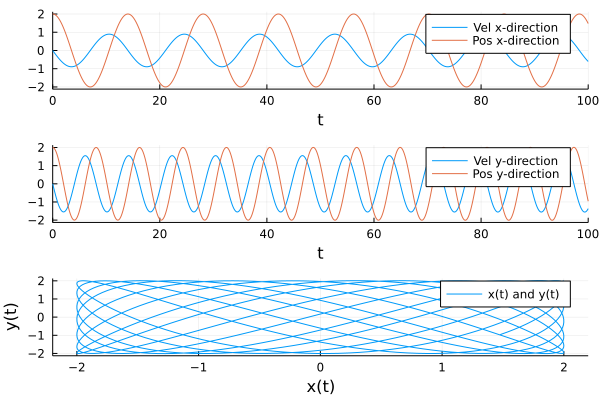

In [31]:
m = 5 
#..set spring constant of spring 
k = 1.0 
#..set damping constant 
c = 0.0 

#..set imposed acceleration on the door 
function f(t)
    #return exp(-(t-2)^2/0.01)
    #return t>=2 
    return 0 
end 

#..define the right-hand side of the ordinary differential equation of the equation of motion 
function mass_system2!(ddu,du,u,p,t)
    # solve \ddot{u} = -(k/m) u - (c/m) \dot u + f(t) 
    ddu[1] = -(k/m)*u[1] + f(t)
    ddu[2] = -(3*k/m)*u[2] + f(t)
end

#..set initial position and velocity
u0 = [2.0, 2.0]                                      
v0 = [0.0, 0.0]
#..set time begin and end forward
tspan = (0.0,100.0)               

#..define ODE problem to be solved  
prob = SecondOrderODEProblem(mass_system2!,v0,u0,tspan)

#..solve ODE problem 
sol = solve(prob)

#..plot the source term
tvec = Vector(0.:0.01:10.)
fvec = f.(tvec)
# p1 = plot(tvec,fvec,label="Excitation")

#..velocity and position have vars=(1,2) and vars=(3,4), respectively. 
plot(sol,vars=1,label="Vel x-direction") 
p1 = plot!(sol,vars=3,label="Pos x-direction")

plot(sol,vars=2,label="Vel y-direction") 
p2 = plot!(sol,vars=4,label="Pos y-direction")

p3 = plot(sol,vars=(3,4),label="x(t) and y(t)")
xlabel!("x(t)") 
ylabel!("y(t)")

#..plot solution of velocity and position as function of time  
plot(p1,p2,p3,layout=(3,1))

### Possible Extensions 

- [one mass, two spring system with longitudinal motion](https://ccrma.stanford.edu/CCRMA/Courses/152/vibrating_systems.html)
- [one mass, two spring system with transversal motion](https://ccrma.stanford.edu/CCRMA/Courses/152/vibrating_systems.html)
- [point-mass in a plane by linear superposition of the previous two cases](https://web.pa.msu.edu/courses/2017fall/PHY321/Alec/52-oct25.lecture.pdf) 

### References 
- [wiki on simple harmonic motion](https://en.wikipedia.org/wiki/Simple_harmonic_motion): no damping is taken into account;
- [wiki on complex harmonic motion](https://en.wikipedia.org/wiki/Complex_harmonic_motion): damping, forcing, resonance; includes a graph of the resonant frequecy;
- [wiki on damping in oscillatory systems](https://en.wikipedia.org/wiki/Damping)
- [wiki on vibrations](https://en.wikipedia.org/wiki/Vibration) interesting for animation of various solutions and explanation of Laplace transform for SDOF and MDOF systems;

## Section 3:/ Door as Interconnection of Three Point Mass 
Assignment: perform parameter study maximal displacement of door as a function of the exitation/impact/amplitiude of external forcing. Consider both in-plane (bus over bump) and perpendicular plane (passenger on door) exitations. 

Approach: subdivide door in three parts: top, middle and bottom part of the door. Assume three parts having equal mass. Top section connected to bus frame (represented as wall) via door arm. Door arm is represented as a spring/damper that is stiff in both x and y direction (large values of kx and ky). Middle section connected to top and bottom section via stiff spring/damoper. Bottom section connected to door frame (represented as wall) via flexible spring. Define and solve system of differential equations for displacement in two spatial coordinates. Experiment with displacement of top, middle and top section. 

Defining systems of differential equations: define spring and damnper matrices using weighted graph Laplacian. Remove row and column corresponding to walls. Define system of differential equations in matrix-vector form in the form ddu[1:3] = Kx*u[1:3] + Cx*du[1:3] + vecf and ddu[4:6] = Ky*u[4:6] + Cy*du[4:6] + vecg. 

In [3]:
# construct 5-by-5 matrix and subsequently 3-by-3 matrix by removing first and last row and column 
kx = [10.; 100.; 1000.; 10.]
#Kx = Tridiagonal()

4-element Vector{Float64}:
   10.0
  100.0
 1000.0
   10.0

In [32]:
m = 5 
#..set spring constant of spring 
k = 1.0 
#..set damping constant 
c = 0.0 

#..set imposed acceleration on the door in x-direction 
function f(t)
    #return t>=1 
    return 0 
end 

#..set imposed acceleration on the door in y-direction 
function g(t)
    #return t>=1 
    return 0 
end 

#..define the right-hand side of the ordinary differential equation of the equation of motion 
function mass_system3!(ddu,du,u,p,t)
    # solve \ddot{u} = -(k/m) u - (c/m) \dot u + f(t) 
    ddu[1:3] = -Kx*u[1:3] - Cx*du[1:3] + [f(t);0]
    ddu[4:6] = -Ky*u[4:6] - Cy*du[1:3] + [g(t); 0; 0]
end

#..set initial position and velocity
u0 = [2.0, 2.0]                                      
v0 = [0.0, 0.0]
#..set time begin and end forward
tspan = (0.0,100.0)               

#..define ODE problem to be solved  
prob = SecondOrderODEProblem(mass_system3!,v0,u0,tspan)

#..solve ODE problem 
sol = solve(prob)

#..plot the source term
tvec = Vector(0.:0.01:10.)
fvec = f.(tvec)
# p1 = plot(tvec,fvec,label="Excitation")

#..velocity and position have vars=(1,2) and vars=(3,4), respectively. 
plot(sol,vars=1,label="Vel x-direction") 
p1 = plot!(sol,vars=3,label="Pos x-direction")

plot(sol,vars=2,label="Vel y-direction") 
p2 = plot!(sol,vars=4,label="Pos y-direction")

p3 = plot(sol,vars=(3,4),label="x(t) and y(t)")
xlabel!("x(t)") 
ylabel!("y(t)")

#..plot solution of velocity and position as function of time  
plot(p1,p2,p3,layout=(3,1))

LoadError: UndefVarError: Kx not defined

### References 
- [Component-Based Modeling of a Mass-Spring System](https://mtk.sciml.ai/stable/tutorials/spring_mass/)

## Section 5/: Door as continuous flexible bar (or plate) 



## References